In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
# from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dense, Input

In [2]:
# Features that will be extracted from the EM data and their shorter handle
wx_params = {
    "temperature_air_mean_200": "temp",
    "wind_speed": "wind",
    "pressure_air_site": "press",
    # "precipitation_height": "precip",
    "sunshine_duration": "sun"
}
outlier_columns=["01228", "02429", "04039", "00656", "00954", "03897", "03946", "00603"]
na_columns = ["00769", "00850", "02437", "00769", "00850", "02303",	"02437", "02564", "03513", "04371"]
# Concatenate all weather parameters into one data frame
wx_dict = {}
for name, handle in wx_params.items():
    wx_dict[handle]=(pd.read_pickle("../data/weather_all_stations/cleaned/"+name+".pkl")).drop(columns=outlier_columns+na_columns)

df = pd.concat(wx_dict.values(), axis=1, ignore_index=False, verify_integrity=True, keys=wx_dict.keys())
df.head()

temp                                          \
                            00102   00161   00164   00183   00198   00232   
2017-01-01 00:00:00+00:00  278.35  268.75  276.65  277.45  270.65  269.45   
2017-01-01 01:00:00+00:00  278.25  268.85  276.75  277.65  270.25  269.25   
2017-01-01 02:00:00+00:00  278.25  269.25  277.05  277.85  269.45  269.05   
2017-01-01 03:00:00+00:00  278.05  269.35  277.15  277.85  269.25  268.55   
2017-01-01 04:00:00+00:00  278.15  269.45  277.55  277.95  268.85  267.85   

                                                           ...   sun        \
                            00282   00298   00303   00342  ... 04177 04271   
2017-01-01 00:00:00+00:00  262.35  277.75  274.75  275.65  ...   0.0   0.0   
2017-01-01 01:00:00+00:00  262.75  277.75  274.65  275.15  ...   0.0   0.0   
2017-01-01 02:00:00+00:00  261.35  277.75  274.35  274.65  ...   0.0   0.0   
2017-01-01 03:00:00+00:00  261.15  277.95  274.55  274.25  ...   0.0   0.0   
2017-01-01 04:00:00+00:00  261.35  277.85  274.75  274.45  ...   0.0   0.0   

                                                                           
                          04336 04393 04464 04466 04501 04625 04642 04745  
2017-01-01 00:00:00+00:00   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2017-01-01 01:00:00+00:00   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2017-01-01 02:00:00+00:00   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2017-01-01 03:00:00+00:00   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2017-01-01 04:00:00+00:00   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 468 columns]

In [3]:
print("column shape: ", df.columns.levshape)
print("df shape: ", df.shape)

column shape:  (4, 117)
df shape:  (43824, 468)


In [4]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
df_train = df[0:int(n*0.7)]
df_val = df[int(n*0.7):int(n*0.9)]
df_test = df[int(n*0.9):]


In [5]:
df_train.shape

(30676, 468)

In [6]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler
scaler = RobustScaler()
scaler.fit(df_train)
# scale all sets according to train set, preserve data frames
df_train = pd.DataFrame(scaler.transform(df_train),
                        columns=df.columns, index=df_train.index).clip(lower=-3)
df_val = pd.DataFrame(scaler.transform(df_val),
                        columns=df.columns, index=df_val.index)
df_test = pd.DataFrame(scaler.transform(df_test),
                        columns=df.columns, index=df_test.index)
plt.figure(figsize=(12, 6))

# ax = sns.violinplot(x="Parameter", y="Rescaled", data=df_train.melt(var_name='Parameter', value_name='Rescaled'))
# _ = ax.set_xticklabels(df.keys(), rotation=90)

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<AxesSubplot:>

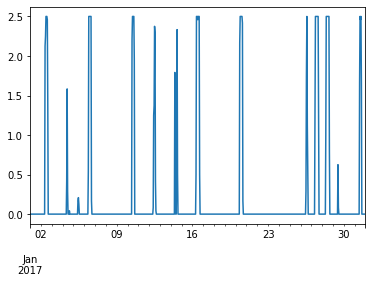

In [7]:
df_train.xs("00183", level=1, axis=1)["sun"].iloc[:31*24].plot()

In [8]:
desc=df_train["wind"].describe().transpose() # .drop(columns=["01228", "02429", "04039", "00656", "00954", "03897", "03946", "00603"]
desc_orig=df["sun"].describe() #

In [9]:
df.columns.levshape
# df.describe()

(4, 117)

In [10]:
X_train = df_train.to_numpy().reshape(-1, *df.columns.levshape)
X_val = df_val.to_numpy().reshape(-1, *df.columns.levshape)
X_test = df_test.to_numpy().reshape(-1, *df.columns.levshape)
input_dim=X_train.shape[1:]

# this fixes the latent space dimension, feel free to play around with
# the values for your own experiments, but leave it at 2 for the assignment
latent_dim = 25
print(input_dim)
print(X_train.shape)
print(df_train.shape)

(4, 117)
(30676, 4, 117)
(30676, 468)


In [11]:
from tensorflow.keras.backend import clear_session

clear_session()
ae=Sequential()
ae.add(layers.Flatten())
ae.add(Dense(latent_dim, input_shape=input_dim,  activation='relu'))
ae.add(Dense(X_train.shape[1]*X_train.shape[2], activation="linear"))
ae.add(layers.Reshape(df.columns.levshape))

# ae.summary()

# plot_model(ae)

In [12]:
# create an input layer with the appropriate shape
input_img = Input(shape=(*input_dim,))
input_lat = Input(shape=(latent_dim,))

# extract the encoder layers
encoder_layer1 = ae.layers[0](input_img)
encoder_layer2 = ae.layers[1](encoder_layer1)

# extract the decoder layers
decoder_layer1 = ae.layers[-2](input_lat)
decoder_layer2 = ae.layers[-1](decoder_layer1)


# make them addressable models
encoder = Model(input_img, encoder_layer2)
decoder = Model(input_lat, decoder_layer2)

encoder.summary()
decoder.summary()

# #plot_model(encoder)
# plot_model(decoder)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 117)]          0         
                                                                 
 flatten (Flatten)           (None, 468)               0         
                                                                 
 dense (Dense)               (None, 25)                11725     
                                                                 
Total params: 11,725
Trainable params: 11,725
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 25)]              0         
                                                                 
 dense_1 (Dense)             (None, 468)

In [13]:
ae.compile(optimizer="adam", loss="mae")
history=ae.fit(X_train, X_train, epochs=15, batch_size=256, shuffle=True, validation_data=(X_val, X_val))

Epoch 1/15
120/120 [==============================] - 1s 5ms/step - loss: 0.4716 - val_loss: 0.3135
Epoch 2/15
120/120 [==============================] - 0s 4ms/step - loss: 0.2901 - val_loss: 0.2733
Epoch 3/15
120/120 [==============================] - 0s 3ms/step - loss: 0.2557 - val_loss: 0.2457
Epoch 4/15
120/120 [==============================] - 0s 4ms/step - loss: 0.2343 - val_loss: 0.2300
Epoch 5/15
120/120 [==============================] - 0s 4ms/step - loss: 0.2227 - val_loss: 0.2215
Epoch 6/15
120/120 [==============================] - 0s 4ms/step - loss: 0.2156 - val_loss: 0.2157
Epoch 7/15
120/120 [==============================] - 0s 4ms/step - loss: 0.2101 - val_loss: 0.2108
Epoch 8/15
120/120 [==============================] - 0s 3ms/step - loss: 0.2055 - val_loss: 0.2078
Epoch 9/15
120/120 [==============================] - 0s 3ms/step - loss: 0.2022 - val_loss: 0.2041
Epoch 10/15
120/120 [==============================] - 0s 4ms/step - loss: 0.1998 - val_loss: 0.2022

(4383, 4, 117)
(4383, 4, 117)
(4383, 468)


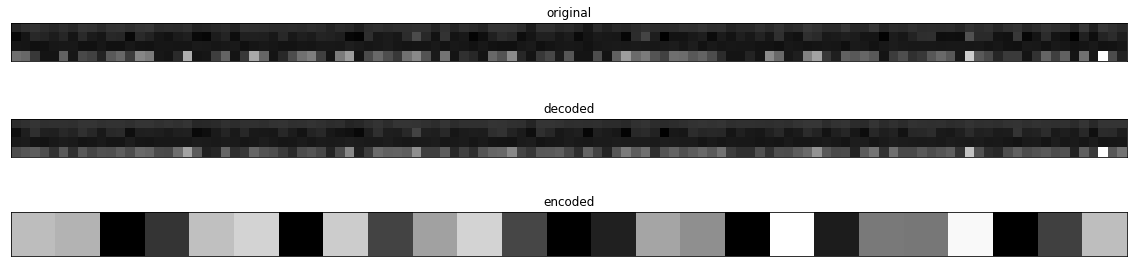

In [14]:
encoded_imgs = encoder(X_test).numpy()
decoded_imgs = decoder(encoded_imgs).numpy()
print(ae.predict(X_test).shape)
print(ae.predict(X_test).reshape(-1, *df.columns.levshape).shape)
print(X_test.reshape(df_test.shape).shape)
transformed_imgs = scaler.inverse_transform(ae.predict(X_test).reshape(df_test.shape)).reshape(-1, *X_test.shape[1:])
# print(reconstructed_imgs[0].shape)
def plot_autoenc(X_test, decoded_imgs, encoded_imgs):
  n = 1
  offset=5
  plt.figure(figsize=(20,5))

  for i in range(n):
    # display original
    ax = plt.subplot(3*n, 1, i + 1)
    # plt.imshow(scaler.inverse_transform(X_test.reshape(df_test.shape))[i+offset].reshape(X_test.shape[1:]))
    plt.imshow(X_test[i+offset])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3*n, 1, i + 2)
    plt.imshow(decoded_imgs[i+offset])
    plt.title("decoded")
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3*n, 1, i + 3)
    plt.imshow(encoded_imgs[i+offset].reshape(latent_dim,1).transpose())
    plt.title("encoded")
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

plot_autoenc(X_test, decoded_imgs, encoded_imgs)

In [15]:
encoded=encoder(scaler.transform(df).reshape(-1, *X_test.shape[1:])).numpy()
enc_df=pd.DataFrame(encoded)

In [16]:
enc_df.to_pickle("../data/weather/encoded_weather_2.pkl")